In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from numpy.random import default_rng
import squidpy as sq
import pandas as pd
import anndata as ad
import moscot as mt
import seaborn as sns
import scanorama

# # sc.set_figure_params()
%load_ext autoreload
%autoreload 2
%load_ext lab_black

2022-11-22 17:58:03.754217: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-11-22 17:58:09.134186: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-11-22 17:58:09.383104: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dyn

In [2]:
from pathlib import Path
import os

root = Path("/lustre/groups/ml01/workspace/moscot_paper/mouse-vizgen")
os.listdir(root)

['datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate1_cell_by_gene_S3R1.csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate2_cell_by_gene_S3R2.csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate3_cell_metadata_S3R3 (1).csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_by_gene_S2R1.csv',
 'adata_full.h5ad',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3 (1).csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2 (1).csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv',
 'datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3 (1).csv',
 'datasets_mouse_brain_map_BrainReceptorShowcas

In [3]:
from itertools import product

adatas = {}
for s, r in product([1, 2, 3], repeat=2):
    print(s, r)
    adata = sq.read.vizgen(
        path=root,
        counts_file=f"datasets_mouse_brain_map_BrainReceptorShowcase_Slice{s}_Replicate{r}_cell_by_gene_S{s}R{r}.csv",
        meta_file=f"datasets_mouse_brain_map_BrainReceptorShowcase_Slice{s}_Replicate{r}_cell_metadata_S{s}R{r}.csv",
    )
    print(adata.shape)
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True
    )
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)

    adatas[f"{s}_{r}"] = adata

1 1
(78329, 483)
1 2
(88884, 483)
1 3
(84636, 483)
2 1
(83546, 483)
2 2
(84172, 483)
2 3
(85958, 483)
3 1
(70844, 483)
3 2
(83461, 483)
3 3
(74866, 483)


In [8]:
list(adatas.keys())

['1_1', '1_2', '1_3', '2_1', '2_2', '2_3', '3_1', '3_2', '3_3']

In [9]:
adata = ad.concat(adatas, label="batch")

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


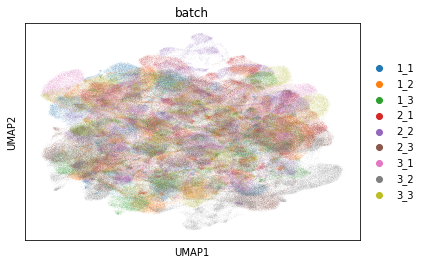

In [11]:
sc.pl.umap(adata, color="batch")

In [12]:
adata.write(root / "adata_full.h5ad")

In [3]:
adata = sc.read(root / "adata_full.h5ad")

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/tmp/ipykernel_122351/2152786260.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


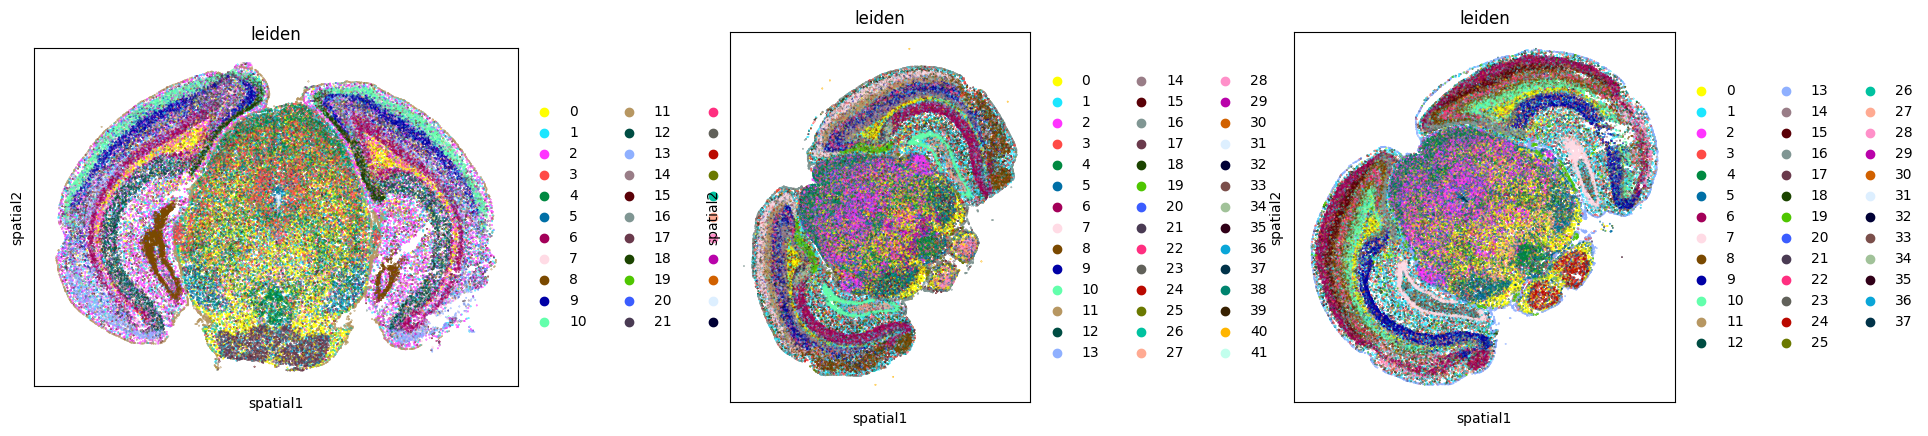

In [4]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    library_key="batch",
    library_id=["1_1", "1_2", "1_3"],
    color="leiden",
)
plt.tight_layout()

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/tmp/ipykernel_122351/3536267512.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


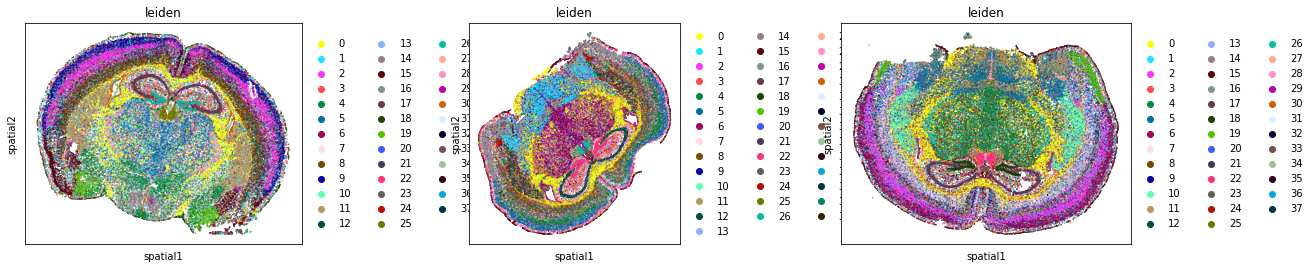

In [5]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    library_key="batch",
    library_id=["2_1", "2_2", "2_3"],
    color="leiden",
)
plt.tight_layout()

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/tmp/ipykernel_122351/3133634128.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


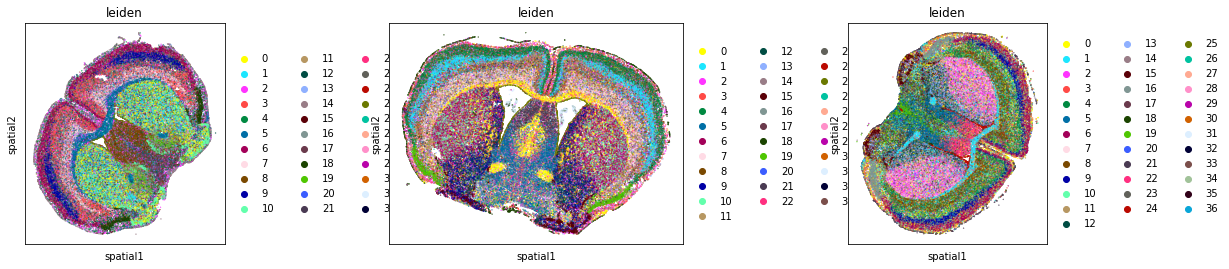

In [6]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    library_key="batch",
    library_id=["3_1", "3_2", "3_3"],
    color="leiden",
)
plt.tight_layout()